<img src="https://avatars.githubusercontent.com/u/1136538?s=70&v=4" align="right"><br><br>
## Using AnyBody from Python

We will use a small open source library to help us. 
**AnyPyTools**

 - Handle all interaction with the console application
 
 - Create macros programatically
 
 - Run simualtions in parallel
 ![alt text](https://github.com/AnyBody-Research-Group/AnyPyTools/raw/master/docs/_static/relax.png)

# How to get started
<br>

### Requirements:

 - A Python installation
 - The `AnyPyTools` library
<br><br>

<img src="anaconda_download.png" alt="Download Anaconda" width="30%" align="right" border="5">

### The easy way:

Install the a Conda Python distribution.
- https://www.anaconda.com/products/individual

Has all the important scientific python packages

More stuff can be installed using the build-in package-manager (`conda`)

    
>``` 
>c:\>conda config --add channels conda-forge
>c:\>conda install anypytools
>```

![install using conda](conda_install.png)



# Running the console applicaiton from Python
<br>

## A simple example
<br>

In [8]:
from anypytools import AnyPyProcess 
app = AnyPyProcess( )

In [9]:
macrolist = [
    'load "Knee.any"',
    'classoperation Main.MyParameter "Set Value" --value="10"',
    'operation Main.MyStudy.Kinematics',
    'run',
    'exit'
] 

app.start_macro(macrolist);

  0%|          | 0/1 [00:00<?, ?it/s]

Completed: 1


## Running multiple macros
<br>

In [10]:
macrolist = [['load "Knee.any"',
              'operation Main.MyStudy.Kinematics',
              'run',
              'exit'],
             ['load "Knee.any"',
              'operation Main.MyStudy.InverseDynamics',
              'run',
              'exit']]

app.start_macro(macrolist); 

  0%|          | 0/2 [00:00<?, ?it/s]

Completed: 2


## Better performance with parallelization

In [4]:
many_macros = [['load "Knee.any"',
                'classoperation Main.MyParameter "Set Value" --value="10"',
                'operation Main.MyStudy.Kinematics',
                'run',
                'exit']]*40

In [ ]:
many_macros

## Better performance with parallelization

First sequentially

In [5]:
app = AnyPyProcess(num_processes = 1)
app.start_macro(many_macros);

[****************100%******************]  40 of 40 complete

Then with parallelization

In [6]:
app = AnyPyProcess(num_processes = 10)
app.start_macro(many_macros); 

[****************100%******************]  40 of 40 complete

# Getting data back from AnyBody
<br>

Usual approach: **AnyOutputFile**, **Save all output data (HDF5 file)**
 - :( Difficult to concatenate data across simulations.
 - :( Impractical if we only need a few variables. 
 

> There must be a better way.

**``...there is... ``**

The console application has a class operation we can use

**``` classoperation <AnyScript_variable_name> "Dump"```**

![Dump classoperation](classoperation_dump.png)

AnyPyTools will automatically grab any data or error from AnyBodyCon

In [7]:
from anypytools import AnyPyProcess 
app = AnyPyProcess( )

macrolist = [['load "Knee.any"',
             'operation Main.MyStudy.InverseDynamics',
             'run',
             'classoperation Main.MyStudy.Output.MaxMuscleActivity "Dump"',
             'exit'], 
            ['load "Knee.any"',
             'operation Main.MyStudy.InverseDynamics',
             'run',
             'classoperation Main.MyStudy.Output.MaxMuscleActivity "Dump"',
             'exit']]

In [8]:
results = app.start_macro(macrolist)

[****************100%******************]  2 of 2 complete

In [ ]:
results  

## Plotting the data

In [9]:
%matplotlib inline
from matplotlib.pyplot import plot 

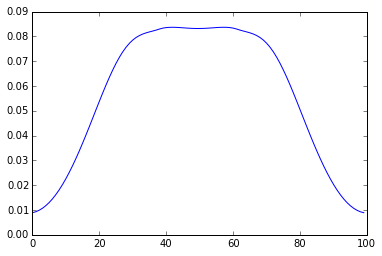

In [10]:
max_muscle_activity = results[0]['Main.MyStudy.Output.MaxMuscleActivity']
plot(max_muscle_activity); 

Output behaves like default Python data types:

- **`list`** and **`dictionary`** types.

But with extra convenience functionality:


In [11]:
results[0]['Main.MyStudy.Output.MaxMuscleActivity'].shape

(100,)

In [12]:
results['Main.MyStudy.Output.MaxMuscleActivity'].shape

(2, 100)

In [13]:
results['MaxMuscleActivity'].shape

(2, 100)

# Handling Errors
<br>

AnyPyTools will also catch Errors...

Here is a macro with misspelled operation:

In [14]:
macrolist = ['load "Knee.any"',
             'operation Main.MyStudy.Kinematic ',
             'run', 
             'exit']  
 

In [15]:
from anypytools import AnyPyProcess 
app = AnyPyProcess( )

result = app.start_macro(macrolist);

[****************100%******************]  1 of 1 complete (1 Error)

In [16]:
result['ERROR']  

array([['Error : Main.MyStudy.Kinematic : Unresolved object.']], 
      dtype='<U51')

# Creating macro programmatically
<br>

### Why would we want to generate macro commands?

- Individual macros can be really long and complex

- Parameter and sensitivity studies may require thoudsands of different macros

In [17]:
%pycat "large_macro.anymcr"

In [ ]:
from anypytools.macro_commands import Load, RunOperation, Export, SetValue

In [19]:
Load("Knee.any") 

load "Knee.any"

In [20]:
SetValue('Main.Model.Parameter1', 100.3)

classoperation Main.Model.Parameter1 "Set Value" --value="100.3"

In [ ]:
macrolist = [ Load('Knee.any'),
              SetValue('Main.MyParameter', 10),
              RunOperation('Main.MyStudy.InverseDynamics'),
              Export('Main.MyStudy.Output.MaxMuscleActivity')] 
macrolist

[load "Knee.any",
 classoperation Main.MyParameter "Set Value" --value="10",
 operation Main.MyStudy.InverseDynamics
 run,
 classoperation Main.MyStudy.Output.MaxMuscleActivity "Dump"]

In [22]:
from anypytools import AnyPyProcess
app = AnyPyProcess()
app.start_macro(macrolist);

[****************100%******************]  1 of 1 complete

### Creating many macros

We need an small helper class `AnyMacro` to wrap our macro list.

In [3]:
from anypytools import AnyMacro

macrolist = AnyMacro( [ SetValue('Main.MyModel.MyParameter',8)] )

macrolist.number_of_macros = 2
macrolist

[['classoperation Main.MyModel.MyParameter "Set Value" --value="8"'],
 ['classoperation Main.MyModel.MyParameter "Set Value" --value="8"']]

In [4]:
parameter_list = [2.2, 2.5, 2.7, 2.9, 3.1]

macrolist = [ SetValue('Main.MyModel.MyParameter',parameter_list)] 

AnyMacro(macrolist, number_of_macros=5) 

[['classoperation Main.MyModel.MyParameter "Set Value" --value="2.2"'],
 ['classoperation Main.MyModel.MyParameter "Set Value" --value="2.5"'],
 ['classoperation Main.MyModel.MyParameter "Set Value" --value="2.7"'],
 ['classoperation Main.MyModel.MyParameter "Set Value" --value="2.9"'],
 ['classoperation Main.MyModel.MyParameter "Set Value" --value="3.1"']]

# A simple parameter study
<br>

<img src="https://github.com/AnyBody-Research-Group/AnyPyTools/blob/master/docs/Tutorial/knee.gif?raw=true" alt="Drawing" align="Right" 
width=160 />
Combine everything in a parameter study
- Vary patella tendon length in toy model (2 cm  to 8 cm)


Observe the effect on maximum muscle activity.

In [25]:
patella_len = [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]

In [ ]:
macro = [Load('Knee.any'),
         SetValue('Main.MyModel.PatellaLigament.DriverPos', patella_len ),
         RunOperation('Main.MyStudy.InverseDynamics'),
         Export('Main.MyStudy.Output.Abscissa.t'), 
         Export('Main.MyModel.PatellaLigament.DriverPos'),
         Export('Main.MyStudy.Output.MaxMuscleActivity')]

parameter_study_macro = AnyMacro(macro, number_of_macros= 7 )

In [ ]:
parameter_study_macro  

In [27]:
from anypytools import AnyPyProcess
app = AnyPyProcess()

output = app.start_macro(parameter_study_macro)

[****************100%******************]  7 of 7 complete

In [28]:
%matplotlib inline
from matplotlib.pyplot import plot, title, xlabel, legend, ylabel

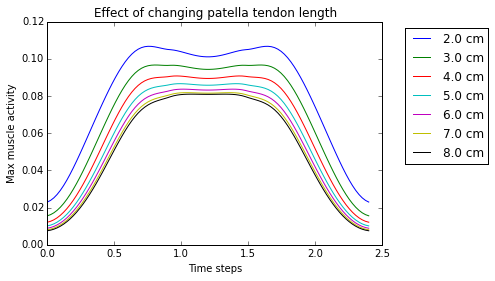

In [29]:
for data in output:
    maxact = data['Main.MyStudy.Output.MaxMuscleActivity']
    time = data['Main.MyStudy.Output.Abscissa.t']
    ligament_len = data['Main.MyModel.PatellaLigament.DriverPos'][0]
    plot(time, maxact, label = str(100* ligament_len)+' cm' )
    
title('Effect of changing patella tendon length')    
xlabel('Time steps')
ylabel('Max muscle activity')
legend(bbox_to_anchor=(1.05, 1), loc=2);

# Batch processing
<br>

The approach depends on how the AnyBody model is structured.

 - Setup with a single main file:
     - Load -> Modify parameters -> run -> save results
     - Every macro is different
     
 - Setup with multiple main files:
      - Each main file defines its own parameters
      - All macros are the same. Main files in Diffent folders



![Batch Process model](batch_process_folder.png)

<img src="batch_process_folder_model.png" alt="Drawing" align="Left" />
<img src="batch_process_mainfile.png" alt="Drawing" align="Right" />

In [ ]:
from anypytools import AnyPyProcess
from anypytools.macro_commands import Load, RunOperation
app = AnyPyProcess(num_processes = 3)

macro = [Load("main.any"),
         RunOperation('Main.Study.InverseDynamics') ]
macro    

[load "main.any", operation Main.Study.InverseDynamics
 run]

In [31]:
app.start_macro(macro, search_subdirs= "model[1-9].*main.any" );

[****************100%******************]  9 of 9 complete

# Other possiblities 
<br>

<img src="MonteCarlo.svg"
     style="height: 250px; margin: 0px 20px 0px 0px; float: right; border: 2px solid gray;"/> 


- Monte Carlo simulations

- Latin hypercube sampling

- Using external optimizers

> Possible topics for a webcast in the fall.

For now... read the tutorial:

## **goo.gl/F6mCHC**

<img src="https://dl.dropboxusercontent.com/u/1683635/store/tutorial.png"
     style="height: 250px; margin: 0px 20px 0px 0px; float: middle; border: 2px solid gray;"/> 

from scipy.stats.distributions import norm

from anypytools import AnyPyProcess, AnyMacro
from anypytools.macro_commands import Load, SetValue_random, RunOperation


app = AnyPyProcess( )
macro = AnyMacro( 
          Load( "Knee.any"),
          SetValue_random('Main.MyModel.MyParameter',
                         norm(0.1, 0.04)),
          RunOperation('Main.MyStudy.InverseDynamics') )
   
app.start_macro(macro.create_macros_MonteCarlo(1000));

In [ ]:
import seaborn as sns
sns.set_context('talk')
sns.set_style('whitegrid');
%matplotlib inline
from matplotlib.pyplot import plot, title, xlabel, legend, ylabel